# Hand Sign Language Recognition using CNN
### Practical Data Science Final Project by __Abdulaziz Al-Harqan and Aigerim Karatay__

## Introduction (Motivation)
__Communication__ is central in how we live. 

However, communication can get difficult for mute people in their daily activities, even in such simple things as ordering food from the drivethrough restaurants. As most of us know, we communicate with the restaurant staff through the microphone at the drivethrough window. There is also a camera that is pretty much useless, but records you so that staff can see you while you speak. 

Mute people, however, cannot use the microphone, and camera cannot do mush as well as most of the staff do not know how to decode sign language. This obviously makes it harder for mute people because they have to type what they want to say everytime, or bring a human translator with them.

Thus, we thought and asked: "How can we understand and recognise the sign language with the help of computers?", so that we can use the cameras to help mute people in the regards as described above. Therefore, we have decided to build the model that predicts sign language letters from the digital images.

## Dataset
We have used __Sign Language MNIST__ dataset from Kaggle that contains he training data (27,455 cases) and test data (7172 cases). 

Each training and test case represents a label (0-24) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because those letters require motion and cannot be captured in an image). 

Dataset contains a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. 

The dataset can be accessed at: https://www.kaggle.com/datasets/datamunge/sign-language-mnist 

Let's import the required libraries in a cell below.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
#To split the data for the model
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout


Retrieving the training and testing data and saving them into dataframes called "train" and "test" accordingly:

In [54]:
train = pd.read_csv("../Project/Data/sign_mnist_train.csv")
test = pd.read_csv("../Project/Data/sign_mnist_test.csv")


Let's check what data train set contains.

In [55]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


Let's check what shape the train set has.

In [56]:
train.shape

(27455, 785)

Let's check what shape the test set has.

In [57]:
test.shape

(7172, 785)

Now, let's explore what are the contents of the dataset.

The labels, as we can see below, are represented by numbers from 0 to 24, where A is represented as 0, B as 1, C as 2, and so on.

In [58]:
train_labels = train.label.values
train_labels

array([ 3,  6,  2, ..., 18, 17, 23])

### Data Analysis
Now let's analyze the data as a whole picture. We start from plotting the data as a bar plot.

<AxesSubplot:ylabel='count'>

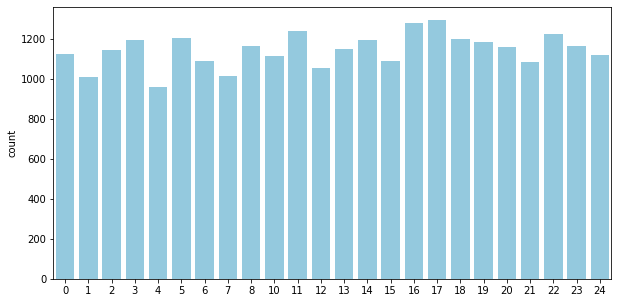

In [59]:
plt.figure(figsize = (10,5))
sns.countplot(x = train_labels, color = "skyblue")

We can interpret that letters are almost equally distributed, all letters betwenn 1000 and 1200 instances in the dataset.

One issue that must be dealt with is labels representation. Since values are represented in numbers (from 0 to 23), higher numbers will be given higher values. This is not desirable, thus we decided to one-hot-encode the labels for the accurate processing. 

In [60]:
label_binrizer = LabelBinarizer()
binary_labels = label_binrizer.fit_transform(train_labels)
binary_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

Since the labels are converted into a one-hot-encoded array, we no longer need the 'label' column in the dataframe, so we drop it.

In [61]:
train.drop('label', axis = 1, inplace = True)

Convert the dataframe into an array of images in the form of list. Each element is an image representation.

In [62]:
train_images = train.values
train_images = np.array([np.reshape(i, (28, 28)) for i in train_images])
train_images = np.array([i.flatten() for i in train_images])
#images[0]

Now lets display some examples of the images array, for example the one below is "C":

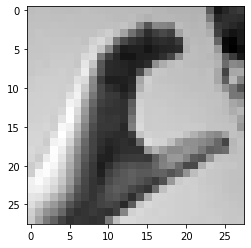

In [63]:
#This is a letter "C"
plt.imshow(train_images[2].reshape(28,28), cmap="gray")

And another one is "S":

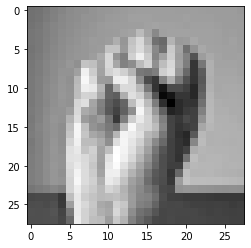

In [64]:
#This is the letter "S"
plt.imshow(train_images[10].reshape(28,28), cmap="gray")

## Model
### CNN to Process Images and Create a Model

We are using Convolutional Neural Networks (CNN) to train the Model. 

CNNs, similar to neural networks, are made up of "neurons" with learnable weights and biases. Each "neuron" receives several inputs, takes a weighted sum over them, pass it through an activation function and responds with an output.

Check more about CNN at https://towardsdatascience.com/coding-a-convolutional-neural-network-cnn-using-keras-sequential-api-ec5211126875. 

We start from splitting the training data into: Training Set (80%) and Validation Set (20%).

__train_images__: an array of lists, each element is a row represented as a list of pixels. Thus, we have a 28x28 representation of images instead of a single long list of 784 elements.

__binary_labels__: is the one-hot-encoding representation of letters.

In [65]:
x_train, x_vald, y_train, y_vald = train_test_split(train_images, binary_labels, test_size = 0.2, random_state = 42)

In [66]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Normalization
Since all the values in the dataframe are pixels ranging from 0-255, we can normalize the value for better performance and ease of processing. We divide all the values by 255, to have the pixels ranging from 0-1.

In [67]:
x_train = x_train / 255
x_vald = x_vald / 255

After normalizing the values, we can reshape the array into a Matrix, each element is a row represented as a list of pixels. Thus, we have a 28x28 representation of images instead of a single long list of 784 elements.

In [68]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_vald = x_vald.reshape(x_vald.shape[0], 28, 28, 1)

### Building the Model
Now we can create the model layers to start the training process.

A convolutional neural network (CNN) consists of an input and an output layer, as well as multiple hidden layers.
The hidden layers of a CNN typically consist of a series of convolutional layers that convolve with a multiplication or other dot product.

The activation function is commonly a RELU layer, and is subsequently followed by additional convolutions such as pooling layers, fully connected layers and normalization layers, referred to as hidden layers because their inputs and outputs are masked by the activation function and final convolution.

Check more about CNN layers at: https://www.kaggle.com/code/prashant111/comprehensive-guide-to-cnn-with-keras.

CNN model below is retrieved from: https://towardsdatascience.com/using-convolutional-neural-network-for-image-classification-5997bfd0ede4

In [69]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=(28, 28 ,1) ))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.20))
#24 because we have a total of 24 classes 
#(letters ranging from A-Y. Excluding J and Z since they're not in the dataset)
model.add(Dense(24, activation = 'softmax'))

After building the model layers we need to compile it.

In [70]:
#model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.compile(loss = keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

Let's check the model that has been compiled by looking at its summary.

In [71]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 64)        

### Training the Model

Now its time to start training the model. To avoid overfitting, we decided to use __EarlyStoppping__ feature. EarlyStopping stops the training when a monitored metric has stopped improving.

As the goal of our training is to minimize the loss, the metric to be monitored would be 'loss', and mode would be 'min'. 

At the end of every epoch __model.fit()__ training loop will check whether the loss is no longer decreasing. Once it has found that loss is no longer decreasing, model.stop_training is marked True and the training terminates.

Check more details about EarlyStopping at https://keras.io/api/callbacks/early_stopping/.

In [72]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5)

In [73]:
history = model.fit(x_train, y_train, epochs = 40, 
                    validation_data = (x_vald, y_vald), batch_size = 200, callbacks=[early_stopping])

Epoch 1/40
110/110 [==============================] - 10s 87ms/step - loss: 2.7505 - accuracy: 0.1665 - val_loss: 1.9378 - val_accuracy: 0.3968
Epoch 2/40
110/110 [==============================] - 11s 97ms/step - loss: 1.4343 - accuracy: 0.5298 - val_loss: 0.9180 - val_accuracy: 0.7223
Epoch 3/40
110/110 [==============================] - 10s 87ms/step - loss: 0.8327 - accuracy: 0.7220 - val_loss: 0.5739 - val_accuracy: 0.8175
Epoch 4/40
110/110 [==============================] - 10s 87ms/step - loss: 0.5520 - accuracy: 0.8111 - val_loss: 0.3853 - val_accuracy: 0.8743
Epoch 5/40
110/110 [==============================] - 9s 86ms/step - loss: 0.3904 - accuracy: 0.8662 - val_loss: 0.2405 - val_accuracy: 0.9253
Epoch 6/40
110/110 [==============================] - 10s 87ms/step - loss: 0.2650 - accuracy: 0.9142 - val_loss: 0.1671 - val_accuracy: 0.9547
Epoch 7/40
110/110 [==============================] - 10s 87ms/step - loss: 0.1860 - accuracy: 0.9411 - val_loss: 0.1133 - val_accuracy: 

Now we perform the same operations on the testing set as we did on the training set.

__Operations are:__
- Store the labels in a variable.
- Drop 'label' column from the testing set dataframe.
- Create an array that holds all the images (28x28).
- One hot encoding the labels.

In [74]:
test_labels = test['label']
test.drop('label', axis = 1, inplace = True)
test_images = test.values
#Reshaping each image(row) to 28x28
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
test_images = np.array([i.flatten() for i in test_images])
test_labels = label_binrizer.fit_transform(test_labels)
#Reshaping 
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
#print(test_images)

Let's check how many instances in the testing set there are.

In [75]:
len(test.values)

7172

In [76]:
test_labels.shape

(7172, 24)

### Prediction
After transforming the testing data to match the training data, we can predict the labels (letters) for the testing images.

In [77]:
y_pred = model.predict(test_images)
y_pred.shape

(7172, 24)

Now we compare the actual labels with the predicted ones

In [78]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, y_pred.round())

0.8476017847183491

### Main Findings

The model's accuracy is around 84.7%, which is decent!

### Conclusion
The accuracy of our model's prediction is decent, however...
The model is limited in scope. It can only predict the sign language letter by letter, but our initial task was to convert the whole speech of mute people into digital sentences in real time. This requires more work put into the model. But as our model can do fundamental prediction, we hope that we can build more complex model in the future that can read letters in real time and convert them to full words and sentences. We also need to work on the prediction accuracy to make it a bit better that it currently is. 

Overall, we hope that our project idea might bring social benefit to the mute people to make their daily lives easier. 

### References
Sign Language MNIST Dataset: https://www.kaggle.com/datasets/datamunge/sign-language-mnist

About CNN: https://towardsdatascience.com/coding-a-convolutional-neural-network-cnn-using-keras-sequential-api-ec5211126875

CNN with Keras: https://www.kaggle.com/code/prashant111/comprehensive-guide-to-cnn-with-keras 

Retreived CNN model: https://towardsdatascience.com/using-convolutional-neural-network-for-image-classification-5997bfd0ede4

EarlyStopping feature in Keras: https://keras.io/api/callbacks/early_stopping/ 

